Import all dependancies

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
import copy as copy
import random as random

# TODO: Handle relative paths correctly so we can all run it independantly and add to the readme where the dataset needs to be stored
dataset_path = r"C:\Users\chris\Desktop\University\Code\ComputerVision\ForestNetDataset"

Initialise Random Seed

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Load the dataset into memory

In [3]:
# Join the directory with each CSV filename.
test_path = os.path.join(dataset_path, "test.csv")
train_path = os.path.join(dataset_path, "train.csv")
validation_path = os.path.join(dataset_path, "val.csv")

# Read the CSV files into pandas DataFrames.
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(validation_path)

# Create a mapping from the string labels to integers based on the training data.
labels = sorted(train_df["merged_label"].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}
print("Label mapping:", label_to_index)


# FOR MODEL DEVELOPMENT JUST USE THE FIRST 128 SAMPLES FROM THE TRAINING SET
# train_df = train_df.head(128)

Label mapping: {'Grassland shrubland': 0, 'Other': 1, 'Plantation': 2, 'Smallholder agriculture': 3}


Balance the training set

In [4]:
# Print counts per class before oversampling
print("Counts per class before oversampling:")
print(train_df["merged_label"].value_counts())

# Get the maximum count among classes
max_count = train_df["merged_label"].value_counts().max()

# For each class, sample max_count examples with replacement.
balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(
    lambda x: x.sample(max_count, replace=True, random_state=42)
).reset_index(drop=True)

print("After oversampling, counts per class:")
print(balanced_train_df["merged_label"].value_counts())
train_df = balanced_train_df

Counts per class before oversampling:
merged_label
Plantation                 686
Smallholder agriculture    556
Other                      231
Grassland shrubland        143
Name: count, dtype: int64
After oversampling, counts per class:
merged_label
Grassland shrubland        686
Other                      686
Plantation                 686
Smallholder agriculture    686
Name: count, dtype: int64


C:\Users\chris\AppData\Local\Temp\ipykernel_28036\1046957484.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = train_df.groupby("merged_label", group_keys=False).apply(


Define DataLoaders for the training and test set

In [5]:

# This class implements the function __getitem__ which means it can be passed into the DataLoader class from pytorch 
# which makes the batch processing much more seamless.
class ForestNetDataset(Dataset):
    def __init__(self, df, dataset_path, transform=None, label_map=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing the image paths and labels.
            dataset_path (str): The base directory for the images.
            transform (callable, optional): A function/transform to apply to the images.
            label_map (dict, optional): Mapping from label names to integers.
        """
        self.df = df
        self.dataset_path = dataset_path
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            image_rel_path = row["example_path"] + "/images/visible/composite.png"
            image_path = os.path.join(self.dataset_path, image_rel_path)
            # Debug: print the image_path to see if it looks correct
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = row["merged_label"]
            if self.label_map is not None:
                label = self.label_map[label]
            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx} from path {image_path}: {e}")
            raise e


# --- Image Transforms ---
# Resize images to 322x322, convert them to tensors, and normalize.
transform = transforms.Compose([
    transforms.Resize((322, 322)),
    transforms.ToTensor(),

    # TODO: Look into calculating these values for our dataset. It probably has a lot more green than other
    # datasets.
    # These normalization values are typical for natural images.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Create Datasets and DataLoaders ---
train_dataset = ForestNetDataset(train_df, dataset_path, transform=transform, label_map=label_to_index)
test_dataset = ForestNetDataset(test_df, dataset_path, transform=transform, label_map=label_to_index)
val_dataset = ForestNetDataset(val_df, dataset_path, transform=transform, label_map=label_to_index)


batch_size = 32
# TO DO: Experiment with different num_workers (I don't know what this does)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle= False, num_workers=0 )

Train and evaluate model

Old 256 by 256 model

In [53]:
# CNN with input images sized 256x256
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             # Convolutional Block 1: Input 3 x 256 x 256 -> Output 16 x 256 x 256, then maxpool to 16 x 128 x 128
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
#             # Convolutional Block 2: 16 x 128 x 128 -> 32 x 128 x 128, then maxpool to 32 x 64 x 64
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
#             # Convolutional Block 3: 32 x 64 x 64 -> 64 x 64 x 64, then maxpool to 64 x 32 x 32
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(64 * 32 * 32, 128),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )
        
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)  # Flatten the features for the classifier
#         x = self.classifier(x)
#         return x

Using device: cuda
Epoch 1/100, Training Loss: 1.2726 Validation Loss: 1.1455 Test Loss: 1.2291
Epoch Time: 259.57s, Estimated time remaining: 25697.13s



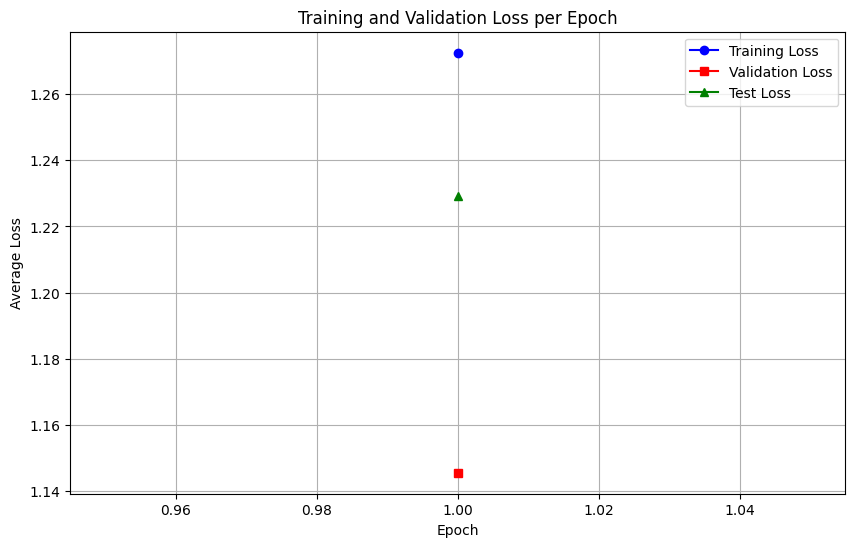

Epoch 2/100, Training Loss: 1.1224 Validation Loss: 1.0277 Test Loss: 1.1722
Epoch Time: 260.19s, Estimated time remaining: 25498.49s



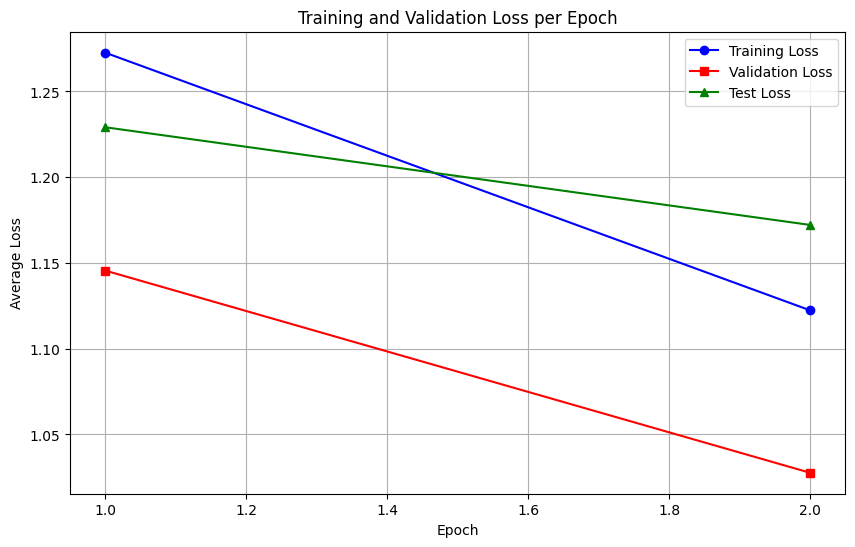

Epoch 3/100, Training Loss: 1.0253 Validation Loss: 1.0019 Test Loss: 1.1601
Epoch Time: 274.37s, Estimated time remaining: 26613.83s



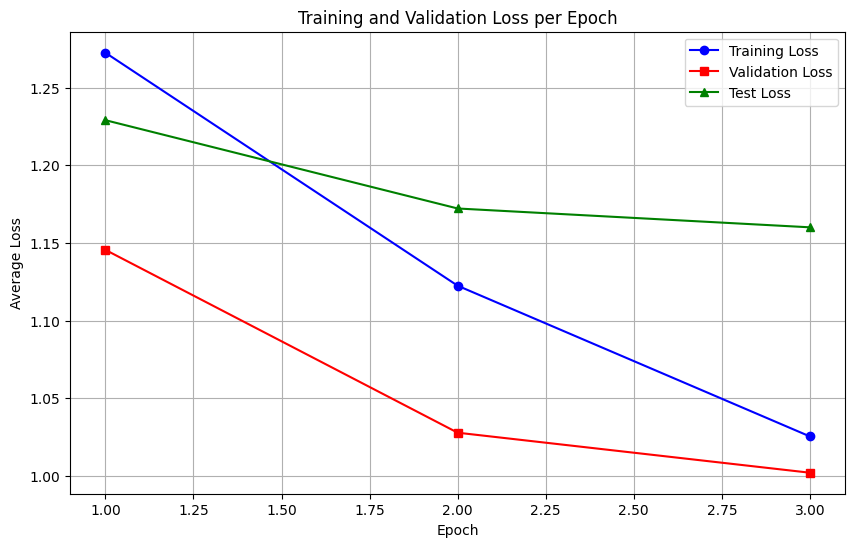

Epoch 4/100, Training Loss: 0.9912 Validation Loss: 1.0305 Test Loss: 1.1455
No improvement for 1 epoch(s).
Epoch Time: 272.20s, Estimated time remaining: 26131.10s



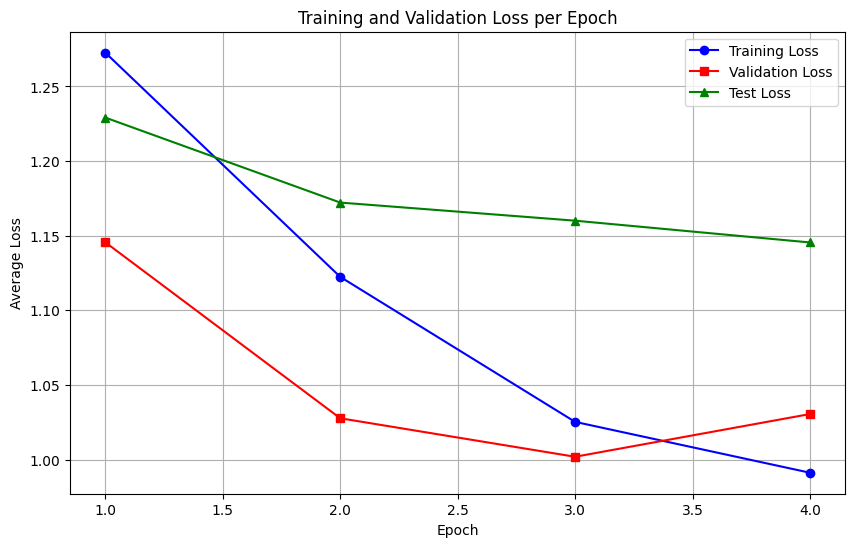

Epoch 5/100, Training Loss: 0.9677 Validation Loss: 0.9855 Test Loss: 1.1565
Epoch Time: 273.65s, Estimated time remaining: 25996.64s



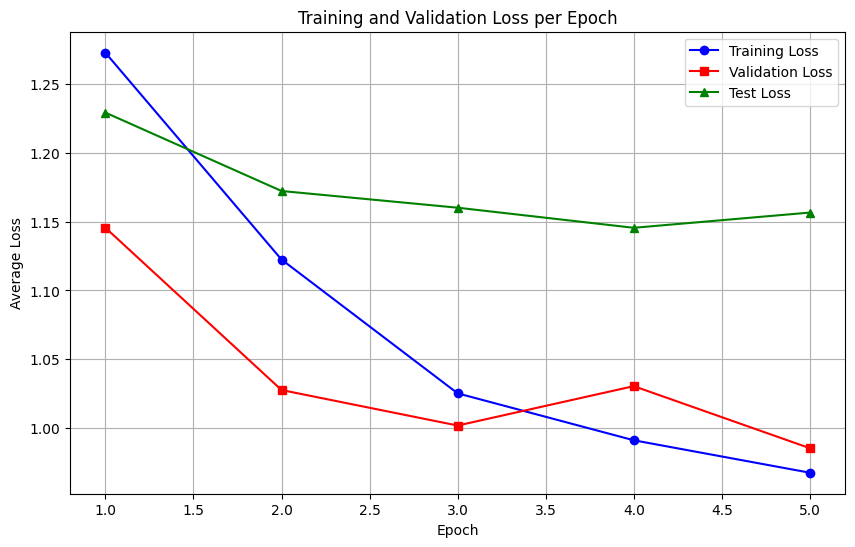

Epoch 6/100, Training Loss: 0.9529 Validation Loss: 0.9775 Test Loss: 1.1288
Epoch Time: 270.78s, Estimated time remaining: 25453.59s



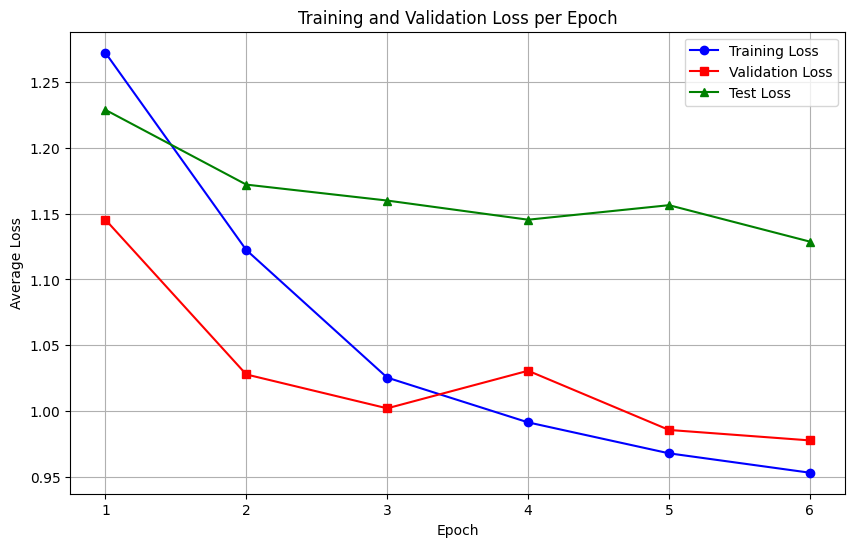

Epoch 7/100, Training Loss: 0.9097 Validation Loss: 1.0684 Test Loss: 1.1684
No improvement for 1 epoch(s).
Epoch Time: 266.87s, Estimated time remaining: 24818.70s



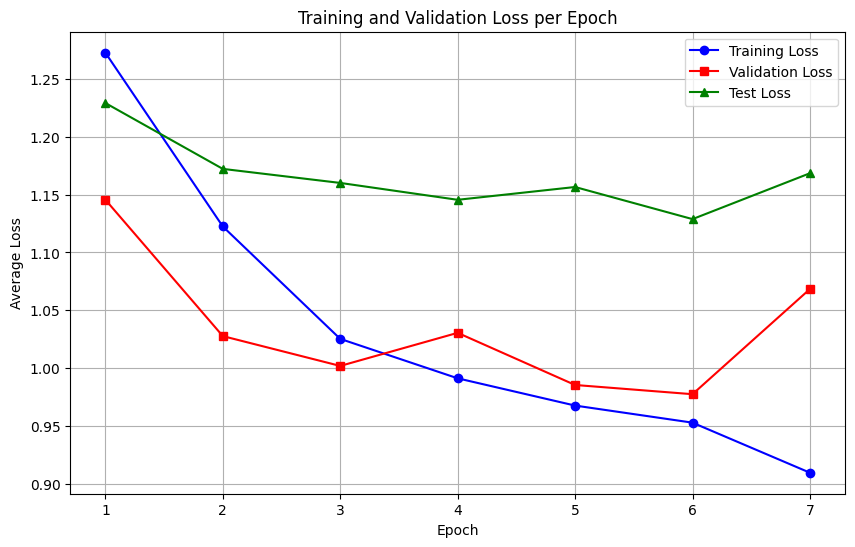

Epoch 8/100, Training Loss: 0.9019 Validation Loss: 1.0295 Test Loss: 1.1522
No improvement for 2 epoch(s).
Epoch Time: 272.61s, Estimated time remaining: 25080.13s



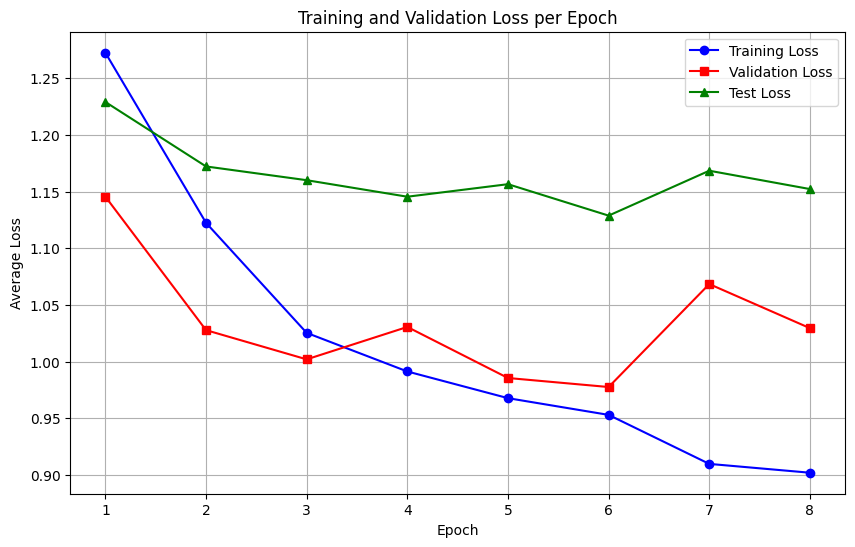

Epoch 9/100, Training Loss: 0.8416 Validation Loss: 1.0562 Test Loss: 1.1317
No improvement for 3 epoch(s).
Validation loss has not improved after many consecutive epochs. Early stopping triggered.
Training complete.
Best model loaded based on validation loss.


In [ ]:
# CNN for size 322 by 322 ie. the max shape of the images
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1: Input 3 x 322 x 322 -> Conv -> 16 x 322 x 322, then maxpool to 16 x 161 x 161
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 2: 16 x 161 x 161 -> Conv -> 32 x 161 x 161, then maxpool to 32 x 80 x 80
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Convolutional Block 3: 32 x 80 x 80 -> Conv -> 64 x 80 x 80, then maxpool to 64 x 40 x 40
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Extra pooling to reduce feature map size from 40 x 40 to 20 x 20
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 20 * 20, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features for the classifier
        x = self.classifier(x)
        return x


class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: Input 3 x 322 x 322 -> Two conv layers -> MaxPool to 32 x 161 x 161
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 2: 32 x 161 x 161 -> Two conv layers -> MaxPool to 64 x 80 x 80
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 3: 64 x 80 x 80 -> Two conv layers -> MaxPool to 128 x 40 x 40
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Block 4: 128 x 40 x 40 -> Two conv layers -> MaxPool to 256 x 20 x 20
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Global average pooling to reduce the feature map to 1x1 per channel.
        # This helps cut down the number of parameters in the classifier.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)  # Now x has shape (batch_size, 256, 1, 1)
        x = x.view(x.size(0), -1)      # Flatten to (batch_size, 256)
        x = self.classifier(x)
        return x


class ResNetTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(ResNetTransferLearning, self).__init__()

        # Load a pre-trained ResNet model (e.g., ResNet50)
        self.resnet = models.resnet50(pretrained=True)

        # Freeze the layers of ResNet (except for the classifier)
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Modify the final layer to match the number of classes in your dataset
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Assume the number of classes is determined by your label mapping:
num_classes = len(label_to_index)
# model = SimpleCNN(num_classes)
# model = EnhancedCNN(num_classes)
model = ResNetTransferLearning(num_classes)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 1
best_model_state = None  # Will hold the best model weights

# Training and Evaluation Loop
num_epochs = 100
training_losses = []
validation_losses = []
test_losses = []
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    epoch_start = time.time()  # Start time for the epoch
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()           # Zero the gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    training_losses.append(epoch_loss)

    # TEST EVALUATION
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # VALIDATION EVALUATION
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    validation_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f} Validation Loss: {epoch_val_loss:.4f} Test Loss: {epoch_test_loss:.4f}")
    
    # --- Early Stopping Check ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")
        if epochs_without_improvement >= patience:
            print("Validation loss has not improved after many consecutive epochs. Early stopping triggered.")
            break
    
    # UNCOMMENT IF YOU WANT TO EVALUATE THE TEST ACCURACY EVERY EPOCH
    # --- Evaluation ---
    # model.eval()
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for images, labels in test_loader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, preds = torch.max(outputs, 1)
    #         correct += (preds == labels).sum().item()
    #         total += labels.size(0)
    # accuracy = correct / total
    # print(f"Test Accuracy: {accuracy:.4f}")

    epoch_end = time.time()  # End time for the epoch
    epoch_duration = epoch_end - epoch_start
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_time_remaining = epoch_duration * remaining_epochs
    print(f"Epoch Time: {epoch_duration:.2f}s, Estimated time remaining: {estimated_time_remaining:.2f}s\n")

    epochs = range(1, len(training_losses) + 1)  # Create epoch numbers starting at 1

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, validation_losses, marker='s', linestyle='-', color='r', label='Validation Loss')
    plt.plot(epochs, test_losses, marker='^', linestyle='-', color='g', label='Test Loss')
    plt.title("Training and Validation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

print("Training complete.")

# Load the best model weights (if they were saved) so that further evaluations use the best model.
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model loaded based on validation loss.")
else:
    print("No best model was saved during training.")


Plot training losses

Classification Report:
                         precision    recall  f1-score   support

    Grassland shrubland     0.2792    0.5584    0.3723        77
                  Other     0.4503    0.7264    0.5560       106
             Plantation     0.8333    0.5948    0.6941       269
Smallholder agriculture     0.7682    0.5370    0.6322       216

               accuracy                         0.5928       668
              macro avg     0.5828    0.6042    0.5636       668
           weighted avg     0.6876    0.5928    0.6151       668



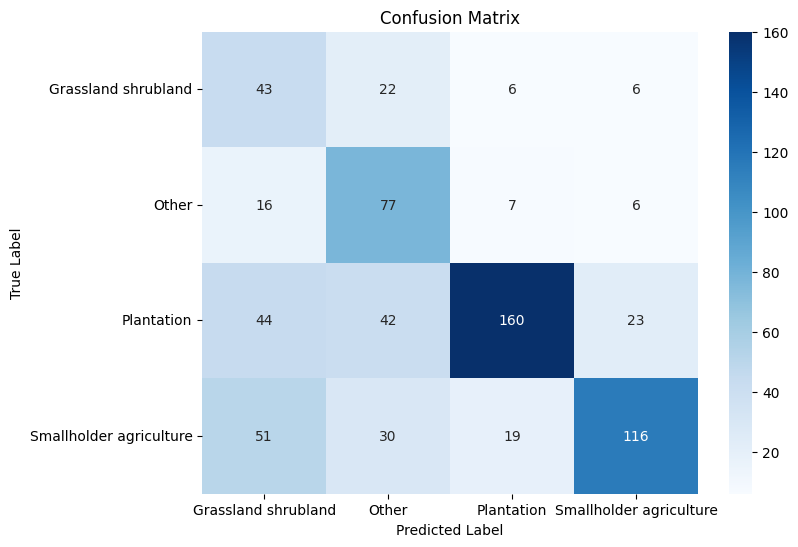

In [12]:
# Create a mapping to convert indices back to labels (for display purposes)
index_to_label = {v: k for k, v in label_to_index.items()}
target_names = [index_to_label[i] for i in range(num_classes)]

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report (includes precision, recall, and F1 score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Print confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap to display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()